# Shortwave Radiation

__J. Potemra__
<br>
_July 2020_


As noted in the [introductary notes](heat_flux.ipynb), net surface shortwave radiation can be viewed as the difference between incoming solar irradiance (or "clear sky") minus absorbtion/reflection by clouds minus any reflection by the ocean surface:

<img src = 'shortwave_cartoon.jpg'>

\begin{eqnarray}
Q_{S}^{Net} = Q_{S}^{Clear} - Q_{S}^{Cloud} - Q_{S}^{Reflect}
\end{eqnarray}

The ratio of reflected to incoming radiation is called the albedo: $\alpha = \frac{Q_{S}^{Reflect}}{Q_{S}^{Clear} - Q_{S}^{Cloud}}$.  The _in-situ_ instruments typically measure $Q_{S}^{Clear} - Q_{S}^{Cloud}$ and assume a value for $\alpha$ to come up with $Q_{S}^{Net}$:

\begin{eqnarray}
Q_{S}^{Net} = Q_{S}^{Clear} - Q_{S}^{Cloud} - Q_{S}^{Reflect} \\
Q_{S}^{Net} = ( 1 - \alpha ) (Q_{S}^{Clear} - Q_{S}^{Cloud}) \\
Q_{S}^{Net} = ( 1 - \alpha ) Q_{S}^{Obs} \\
\end{eqnarray}

Note that all we have is the reported net shortwave radiation, $Q_{S}^{Net}$, but it appears that the tropical sites use a constant albedo of 5 percent, thus $Q_{S}^{Net}/0.95$ should give the buoy recorded net downward shortwave ($Q_{S}^{Clear} - Q_{S}^{Cloud}$).

Here we will compare shortwave radiation ($Q_{S}$) as measured from instruments and the operational coupled climate model CFSv2.  In addition, we use various parameterizations of clear-sky irradiance to try and determine both the impact (and characterization of) clouds and also to see if this can explain observations/model differences.

The first step will be to compare the observations made on the roof of the HIG building on the UH Manoa campus.  During a three-day period in May 2020, observations show relatively cloud-free conditions.  This, then, can be used to compare with computed clear-sky radiance.

Next, we compare the shortwave radiation observed at the WHOTS mooring to the CFSv2 model.  The buoy measures net downward radiation, uses a constant albedo to compute upward, and reports the net.  The model also reports upward and downward (and net).  The model/obs shortwave is then compared to clear-sky estimates in an attempt to resolve cloud-related impacts.

Finally, the observations and model values are binned/aggregated to better understand the differences (_e.g._, daily/monthly sum, low-pass filtered, _etc._).

## 1. Calculation of clear-sky radiance

In this section we compare the differences between a variety of ways of computing clear sky radiance.  For comparison, there is a radiometer on the roof at HIG that measures incoming shortwave (so clouds are already taken into account but not albedo effects).

The data come from https://uhmmeteorology.westernweathergroup.com/ and a three-day sample (with relatively few clouds) was taken during May 15 - 17 2020.

<img src="May15_shortwave_ATMO.png">
          
| Date | Hour | Qs | Date | Hour | Qs | Date | Hour | Qs |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| May 15 |00|    0| May 16 |00|    0| May 17 |00|    0|  
|   .    |01|    0|   .    |01|    0|   .    |01|    0|  
|   .    |02|    0|   .    |02|    0|   .    |02|    0|  
|   .    |03|    0|   .    |03|    0|   .    |03|    0|  
|   .    |04|    0|   .    |04|    0|   .    |04|    0|  
|   .    |05|    0|   .    |05|    0|   .    |05|    0|  
|   .    |06|    0|   .    |06|    0|   .    |06|    0|  
|   .    |07|   69|   .    |07|   51|   .    |07|   61| 
|   .    |08|  304|   .    |08|  282|   .    |08|  302|
|   .    |09|  542|   .    |09|  542|   .    |09|  541|
|   .    |10|  735|   .    |10|  747|   .    |10|  750|
|   .    |11|  915|   .    |11|  910|   .    |11|  917|
|   .    |12|  968|   .    |12| 1013|   .    |12| 1018|
|   .    |13| 1050|   .    |13| 1049|   .    |13| 1052|
|   .    |14| 1008|   .    |14| 1015|   .    |14| 1017|
|   .    |15|  900|   .    |15|  912|   .    |15|  912|
|   .    |16|  707|   .    |16|  713|   .    |16|  716|
|   .    |17|  530|   .    |17|  540|   .    |17|  541|
|   .    |18|  304|   .    |18|  310|   .    |18|  317|
|   .    |19|   92|   .    |19|  100|   .    |19|   84| 
|   .    |20|    0|   .    |20|    0|   .    |20|    0|  
|   .    |21|    0|   .    |21|    0|   .    |21|    0|  
|   .    |22|    0|   .    |22|    0|   .    |22|    0|  
|   .    |23|    0|   .    |23|    0|   .    |23|    0|  

For this example, it is important to note:
* Time reported is local HST that is 10 hours off from UTC
* The lat/lon of the HIG instrument is 21.2980459, -157.8187884

There are three different methods compared here.  First, is based on Ohlmann and Siegel (2000).  This code is based on a matlab routine from Fernando Santiago-Mandujano.  Next, the python package __pysolar__ is used (see https://pysolar.readthedocs.io/en/latest/).  Finally, the python package __pvlib__ is used (see https://pvlib-python.readthedocs.io/en/stable/clearsky.html)

<font color='red'>
NOTES: 
    
1. I make the timezone as a negative number for Hawaii as western longitude is expressed as a negative number.  For example, TZ = (-157 * 24 / 360).  The Ohlmann calculation converts this as "day + TZ" while the other two as "time - TZ"

2. The more precise time-zone offset, based on longitude (lon*24/360) is used to get a better representation of solar angle during the day, however, the more straightforward time-zone offset (_e.g._, UTC+10 for Hawaii) is used to represent wall time
</font> 

In [1]:
# import necessary packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from scipy.io import loadmat
from datetime import datetime, timedelta
from pysolar.solar import *
import pvlib
from pvlib import clearsky, atmosphere, solarposition
from pvlib.location import Location
from pvlib.iotools import read_tmy3

In [2]:
# Method 1: Ohlmann and Siegel

def clear_sky1( time, lat, lon, date, TZ ):
    
    # Calculate solar declination
    mtime = pd.to_datetime(time, unit='h', origin = pd.Timestamp(date))
    year = mtime.year
    mon = mtime.month
    day = mtime.day
    hour = mtime.hour
    minu = mtime.minute
    sec = mtime.second

    fi = 23.44                                             # Tropic of Cancer latitude (deg)
    ty = 173.0                                             # day of summer solstice
    dyy = 365.25                                           # average number of days per year
    td = mtime.dayofyear + ( TZ / 24.0  )                  # day of year
    decl = fi * np.cos( 2.0 * np.pi * ( td - ty ) / dyy )  # declination (deg)
    
    # Calculate solar time, hour of the day from midnight
    stdmerid = 15.0 * TZ
    locmerid = lon
    x = 360.0 * ( td - 81.0 ) / dyy
    x = x * np.pi / 180.0
    eot = 9.87 * np.sin(2*x) - 7.53 * np.cos(x) - 1.5 * np.sin(x)
    tc = ( locmerid - stdmerid ) * 4 + eot
    #[yr,mo,dy,hr,mn,sc] = datevec(td)
    loctime = hour + minu / 60.0 + sec / 3600.0
    st = loctime + tc / 60.0
   
    # Calculate Zenith angle
    lat_r = lat * np.pi / 180.0   # latitude (radians)
    decl_r = decl * np.pi / 180.0 # declination (radians)
    t0 = 12
    a = np.sin( lat_r ) * np.sin( decl_r )
    b = np.pi / 180.0 * ( 180.0 * ( st - t0 ) / t0 )
    c = np.cos( lat_r ) * np.cos( decl_r ) * np.cos( b )
    zh = np.arccos( a + c )         # Zenith angle (radians)
    
    # Calculate surface irradiance under clear sky
    # (from Lumb, 1964, see Soloviev and Lukas, 2014, page 22)
    aL = 0.61
    bL = 0.2
    ma = aL + bL * np.cos( zh )
    #Io = 1350  # Solar constant (solar irradiance at top of atmosphere, Lumb, 1964)
    Io = 1365   # Solar constant (solar irradiance at top of atmosphere)
    Iclr = ma * Io * np.cos(zh)
    if Iclr < 0:
        Iclr = 0.0
    
    return Iclr

In [3]:
# Method 2: pysolar

def clear_sky2( time, lat, lon, date, TZ ):
    time = time - TZ
    mtime = pd.to_datetime(time, unit='h', origin = pd.Timestamp(date), utc = True)
    altitude_deg = get_altitude(lat, lon, mtime)
    Iclr = radiation.get_radiation_direct(mtime, altitude_deg)
    if ( Iclr < 0.0 ):
        Iclr = 0.0
    return Iclr

In [4]:
# Method 3: pvlib

def clear_sky3( time, lat, lon, date, TZ ):
    tus = Location(lat, lon, 'US/Hawaii', 700, 'Honolulu')
    res = [time - TZ]
    mtime = pd.to_datetime(res, unit='h', origin = pd.Timestamp(date))
    cs = tus.get_clearsky(mtime)  # ineichen with climatology table by default
    # row = 0; columns are ghi (Global Horizontal Irradiance), dni (Direct Normal Irradiance), 
    #          and dhi (Diffuse Horizontal Irradiance) [0,1,2]; here we just use DNI
    Iclr = cs.iloc[0,0]
    return Iclr

In [5]:
# We will make a comparison to some roof-top observations at the HIG building,
# so here we set the appropriate lat/lon

lat = 21.2980459
lon = -157.8187884
TZ = lon * 24.0 / 360.0
t_ref = '2020-05-15 00:00:00'

# Note that for this comparison, the observerations were made hourly for three
# days in May 2020 (May 15, 16, 17), so we use that as the reference time

/anaconda3/lib/python3.7/site-packages/pysolar/solartime.py:112: UserWarning: I don't know about leap seconds after 2018
  (leap_seconds_base_year + len(leap_seconds_adjustments) - 1)
/anaconda3/lib/python3.7/site-packages/pysolar/solartime.py:112: UserWarning: I don't know about leap seconds after 2018
  (leap_seconds_base_year + len(leap_seconds_adjustments) - 1)


<Figure size 432x288 with 0 Axes>

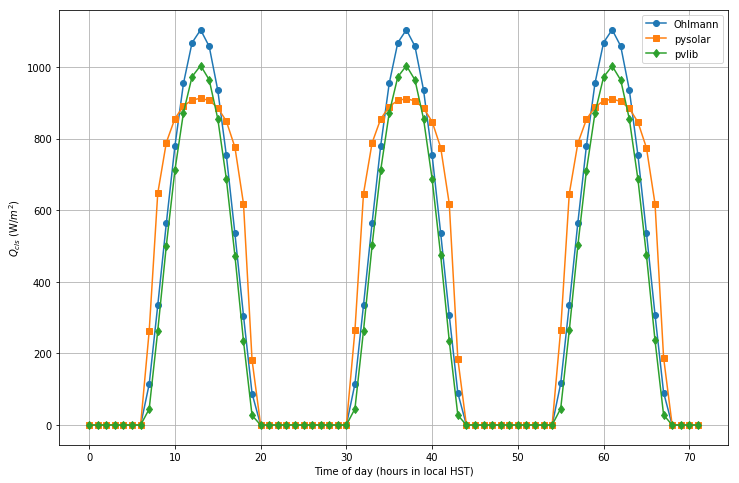

In [6]:
# Now let's make a comparison plot

cls1 = []
cls2 = []
cls3 = []

# Specify 3-day period at hourly interval, 3*24 points
for i in range(72):
  cls1 = np.append(cls1,clear_sky1(i-1,lat,lon,t_ref,TZ))
  cls2 = np.append(cls2,clear_sky2(i-1,lat,lon,t_ref,TZ))
  cls3 = np.append(cls3,clear_sky3(i-1,lat,lon,t_ref,TZ))

plt.figure()
fig = plt.figure( figsize=(12, 8) )
plt.plot(cls1,'o-',label='Ohlmann')
plt.plot(cls2,'s-',label='pysolar')
plt.plot(cls3,'d-',label='pvlib')
plt.legend()
plt.xlabel('Time of day (hours in local HST)')
plt.ylabel('$Q_{cls}$ (W/$m^2$)')
plt.grid()

# save figure
plt.savefig('cls_ideal.png')

<Figure size 432x288 with 0 Axes>

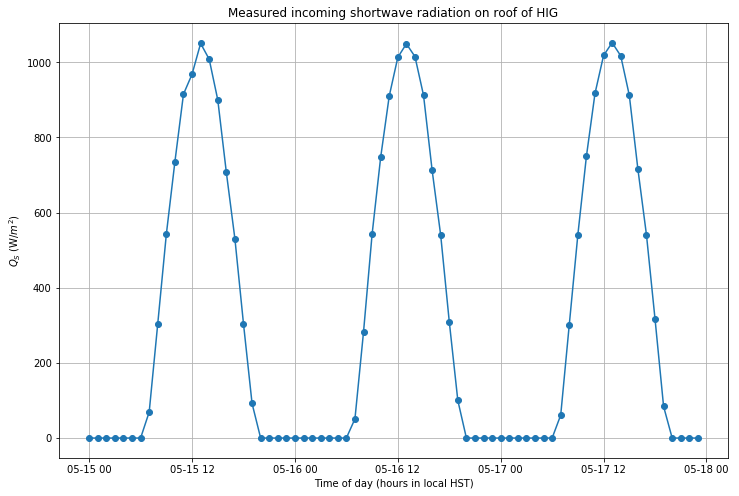

In [7]:
# Now let's read the observations

data = pd.read_csv('May15_shortwave_ATMO.dat', header=None)
Qs = data[1]
date = pd.to_datetime(data.index*3600.0, origin = t_ref, unit='s')
plt.figure()
fig = plt.figure( figsize=(12, 8) )
plt.plot(date,Qs,'o-')
plt.xlabel('Time of day (hours in local HST)')
plt.ylabel('$Q_{S}$ (W/$m^2$)')
plt.title('Measured incoming shortwave radiation on roof of HIG')
plt.grid()

# save figure
plt.savefig('qs_hig.png')

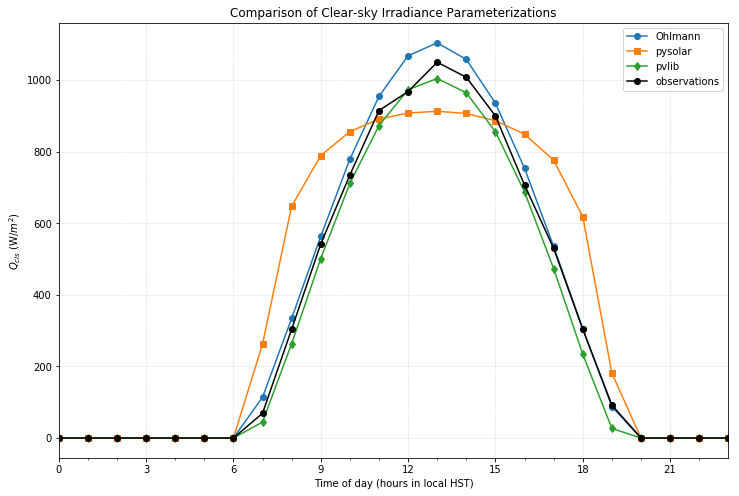

In [8]:
# Now compare the three computed and one measured.  (NOTE: the observations are measured, so they
# include clouds; the other three are idealized clear-sky, i.e., no clouds)

fig, ax = plt.subplots( figsize = ( 12, 8 ) )

major_ticks = np.arange(0, 23, 3)
minor_ticks = np.arange(0, 23, 1)

ax.plot(cls1,'o-',label='Ohlmann')
ax.plot(cls2,'s-',label='pysolar')
ax.plot(cls3,'d-',label='pvlib')
ax.plot(Qs,'ko-',label='observations')

ax.set_xlim(0,23)
ax.set_title('Comparison of Clear-sky Irradiance Parameterizations')
ax.set_xlabel('Time of day (hours in local HST)')
ax.set_ylabel('$Q_{cls}$ (W/$m^2$)')
ax.legend()
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(linestyle=':', linewidth=0.5)

# save figure
plt.savefig('obs-ideal_clearsky.png')

Interesting notes:
* idealized calculations seem to lead the observations by an hour
 * the three idealized calculations suggest sunrise an hour before the observations (at 05:00 instead of 06:00)
 * hard to tell, but looks like peak $Q_{S}$ is also earlier in the idealized cases (12:00 instead of 13:00)
 * finally, the idealized curves show sunset an hour prior to obs (19:00 instead of 20:00)
* the pvlib peak is a little small; the clear sky should always exceed the measured (since obs may have clouds)
* pysolar gives a more broad curve (ala negative kertosis)

## 2.  Comparison to Ocean Reference Site (ORS) and operational model (CFSv2)

We now repeat this exercise, but use the mooring-based measurements of $Q_{S}$.  Note that the calculation of clear-sky took a very long time, so it was done once off-line, and the results were saved as a pickle file.

In [5]:
site = 'WHOTS'

if site == 'WHOTS':
    lat = 22.7667
    lon = -157.8983
    tz_offset = 10.0
if site == 'NTAS':
    lat = 14.75
    lon = -51.25
    tz_offset = 3.0
if site == 'Stratus':
    lat = -20.00
    lon = -85.25
    tz_offset = 6
    
TZ = lon * 24.0 / 360.0

In [6]:
# load CFSv2 data; note the model provides both upward and downward Qs
data = np.loadtxt('/Users/jimp/Research/whoi/cfs/' + site + '_dswsfc.dat')
cfs_qs_down = data[:,1]
data = np.loadtxt('/Users/jimp/Research/whoi/cfs/' + site + '_uswsfc.dat')
cfs_qs_up = data[:,1]
data = np.loadtxt('/Users/jimp/Research/whoi/cfs/' + site + '_prate.dat')
cfs_rain = data[:,1] * 3600.0
cfs_time = pd.to_datetime([i for i in range(len(cfs_qs_up))], unit='h', origin = pd.Timestamp('1979-01-01 00:00:00'))

In [7]:
def matlab2datetime(matlab_datenum):
    day = datetime.datetime.fromordinal(int(matlab_datenum))
    dayfrac = datetime.timedelta(days=matlab_datenum%1) - datetime.timedelta(days = 366)
    return day + dayfrac

In [8]:
# load ORS obs

# WHOTS
if site == 'WHOTS':
    fin1 = loadmat('/Users/jimp/Research/whoi/obs/data/whots1to9_best_flux_1hr.mat',squeeze_me=True)
    fin2 = loadmat('/Users/jimp/Research/whoi/obs/data/whots1to9_best_met_1hr.mat',squeeze_me=True)
    obs_qs = fin1['Qs']
    obs_rain = fin2['prate']

    fin1 = loadmat('/Users/jimp/Research/whoi/obs/data/whots10_flux_1hr.mat',squeeze_me=True)
    fin2 = loadmat('/Users/jimp/Research/whoi/obs/data/whots10_met_1hr.mat',squeeze_me=True)
    data = fin1['Qs']
    obs_qs = np.append ( obs_qs, data[82:] )
    data = fin2['prate']
    obs_rain = np.append ( obs_rain, data[82:])
   
    fin1 = loadmat('/Users/jimp/Research/whoi/obs/data/whots11_flux_1hr.mat',squeeze_me=True)
    fin2 = loadmat('/Users/jimp/Research/whoi/obs/data/whots11_met_1hr.mat',squeeze_me=True)
    data = fin1['Qs']
    obs_qs = np.append ( obs_qs, data[84:] )
    data = fin2['prate']
    obs_rain = np.append ( obs_rain, data[84:] )

    fin1 = loadmat('/Users/jimp/Research/whoi/obs/data/whots12_flux_1hr.mat',squeeze_me=True)
    fin2 = loadmat('/Users/jimp/Research/whoi/obs/data/whots12_met_1hr.mat',squeeze_me=True)
    data = fin1['Qs']
    obs_qs = np.append ( obs_qs, data[60:] )
    data = fin2['prate']
    obs_rain = np.append ( obs_rain, data[60:] )
    
    fin1 = loadmat('/Users/jimp/Research/whoi/obs/data/whots13_flux_1hr.mat',squeeze_me=True)
    fin2 = loadmat('/Users/jimp/Research/whoi/obs/data/whots13_met_1hr.mat',squeeze_me=True)
    data = fin1['Qs'] 
    obs_qs = np.append ( obs_qs, data[54:] )
    data = fin2['prate'] 
    obs_rain = np.append ( obs_rain, data[54:] )
    
    obs_time = pd.date_range('2004-08-13 04:30:00', '2017-07-31 15:30:00', freq='H')
    
# Stratus
if site == 'Stratus':
    '''
    fin = loadmat('/Users/jimp/Research/whoi/obs/data/str1to10_best_flux_1hr.mat',\
                    squeeze_me=True)
    otime = fin['mday']
    obs_qs = fin['Qs']
    fin = loadmat('/Users/jimp/Research/whoi/obs/data/str11to14_best_flux_1hr.mat',\
                   squeeze_me=True)
    data = fin['mday']
    otime = np.append ( otime, data )
    data = fin['Qs']
    obs_qs = np.append ( obs_qs, data )
    obs_time = [matlab2datetime(tval) for tval in otime]
    obs_time = pd.to_datetime(pd.Series(obs_time))
    '''
    fin1 = Dataset('/Users/jimp/Research/whoi/obs/data/OS_Stratus_2000-2010_D_FLTS-1hr.nc', 'r')
    fin2 = Dataset('/Users/jimp/Research/whoi/obs/data/OS_Stratus_2000-2010_D_MLTS-1hr.nc', 'r')
    obs_time = np.array(fin1.variables['TIME'])
    obs_rain = np.array(fin2.variables['RAIN'])
    obs_qs = np.array(fin1.variables['QS'])  

    fin1 = Dataset('/Users/jimp/Research/whoi/obs/data/OS_Stratus_2011-2015_D_FLTS-1hr_orig.nc', 'r')
    fin2 = Dataset('/Users/jimp/Research/whoi/obs/data/OS_Stratus_2011-2015_D_MLTS-1hr.nc', 'r')
    data = np.array(fin1.variables['TIME'])
    obs_time = np.append(obs_time,data)
    data = np.array(fin2.variables['RAIN'])
    obs_rain = np.append(obs_rain,data)
    data = np.array(fin1.variables['QS'])  
    obs_qs = np.append(obs_qs,data)
    
    obs_time = pd.to_datetime(obs_time, unit='d', origin = pd.Timestamp('1950-01-01 00:00:00'))
    
# NTAS
if site == 'NTAS':
    fin1 = Dataset('/Users/jimp/Research/whoi/obs/data/OS_NTAS_2001-2012_D_FLTS-1hr.nc', 'r')
    fin2 = Dataset('/Users/jimp/Research/whoi/obs/data/OS_NTAS_2001-2012_D_MLTS-1hr.nc', 'r')
    obs_time = np.array(fin1.variables['TIME'])
    obs_rain = np.array(fin2.variables['RAIN'])
    obs_qs = np.array(fin1.variables['QS'])
    
    obs_time = pd.to_datetime(obs_time, unit='d', origin = pd.Timestamp('1950-01-01 00:00:00'))

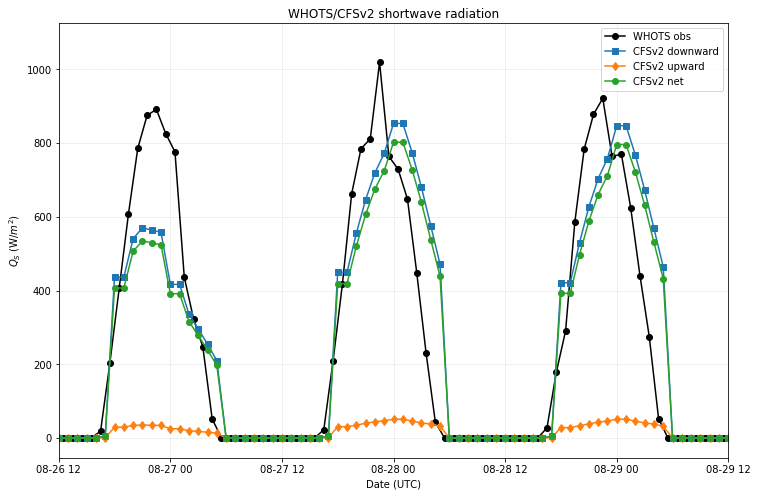

In [9]:
# Plot an arbitrary three-day period
t_ref = '2015-08-26 12:00:00'
fig, ax = plt.subplots( figsize = ( 12, 8 ) )
ax.plot(obs_time,obs_qs,'ko-',label=site + ' obs')
ax.plot(cfs_time,cfs_qs_down,'s-',label='CFSv2 downward')
ax.plot(cfs_time,cfs_qs_up,'d-',label='CFSv2 upward')
ax.plot(cfs_time,cfs_qs_down-cfs_qs_up,'o-',label='CFSv2 net')
ax.set_xlim([datetime.datetime(2015, 8, 26, 12), datetime.datetime(2015, 8, 29, 12)])
ax.set_title(site+'/CFSv2 shortwave radiation')
ax.set_xlabel('Date (UTC)')
ax.set_ylabel('$Q_{S}$ (W/$m^2$)')
ax.legend()
ax.grid(linestyle=':', linewidth=0.5)

In [10]:
# convert the model and observation time from UTC to local time to match computed values
obs_time = obs_time - pd.tseries.offsets.DateOffset(hours=tz_offset)
cfs_time = cfs_time - pd.tseries.offsets.DateOffset(hours=tz_offset)

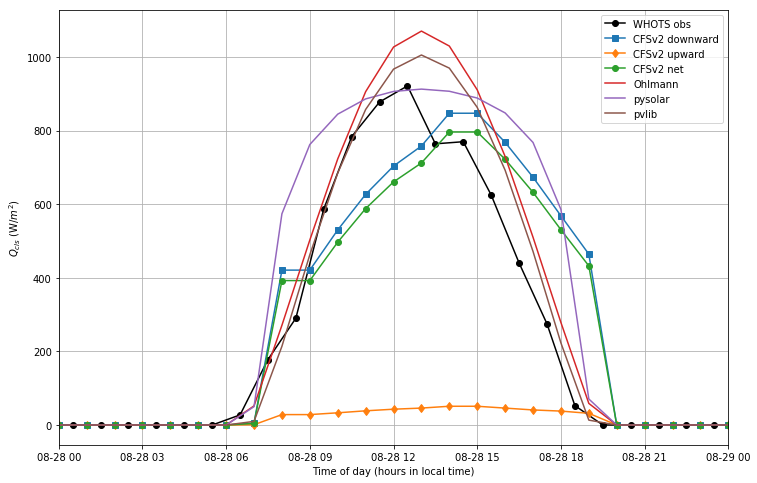

In [11]:
# Add in comparison to parameterizations
cls1 = []
cls2 = []
cls3 = []
#for i in range(len(cfs_qs)):
# Specify 3-day period at hourly interval, 3*24 points
for i in range(72):
  cls1 = np.append(cls1,clear_sky1(i-1,lat,lon,t_ref,TZ))
  cls2 = np.append(cls2,clear_sky2(i-1,lat,lon,t_ref,TZ))
  cls3 = np.append(cls3,clear_sky3(i-1,lat,lon,t_ref,TZ))
itime = pd.to_datetime([i for i in range(72)], unit='h', origin = pd.Timestamp('2015-08-26 12:00:00'))

fig, ax = plt.subplots( figsize = ( 12, 8 ) )
ax.plot(obs_time,obs_qs,'ko-',label=site+' obs')
ax.plot(cfs_time,cfs_qs_down,'s-',label='CFSv2 downward')
ax.plot(cfs_time,cfs_qs_up,'d-',label='CFSv2 upward')
ax.plot(cfs_time,cfs_qs_down-cfs_qs_up,'o-',label='CFSv2 net')
ax.set_xlim([datetime.datetime(2015, 8, 28, 0), datetime.datetime(2015, 8, 29, 0)])

plt.plot(itime,cls1,'-',label='Ohlmann')
plt.plot(itime,cls2,'-',label='pysolar')
plt.plot(itime,cls3,'-',label='pvlib')
plt.legend()
plt.xlabel('Time of day (hours in local time)')
plt.ylabel('$Q_{cls}$ (W/$m^2$)')
plt.grid()
plt.savefig('WHOTS_CFS_Qs_comp.png',format='png')

Interesting notes:
* CFSv2 lags both idealized and observed by two hours
* pysolar gives a more broad curve (ala negative kertosis)


In [12]:
'''
One way to do this is "in-line", but it takes about 4 or 5 hours to run
so instead I've run it "off-line" using make_cls.py and put the results in 
a pickle file, then just read that here
'''
import pickle
file_Name = 'clear_sky_3comp_' + site
fileObject = open(file_Name,'rb')
cls_data = pickle.load(fileObject)
fileObject.close()

In [13]:
cls_data

,Time,ohlmann,pysolar,pvlib
0,1978-12-31 14:00:00,603.034144,981.437617,605.252404
1,1978-12-31 15:00:00,452.335252,919.750347,440.389401
2,1978-12-31 16:00:00,269.389911,773.247715,230.888738
3,1978-12-31 17:00:00,76.737448,279.981449,28.003922
4,1978-12-31 18:00:00,0.000000,0.000000,0.000000
...,...,...,...,...
350635,2018-12-31 09:00:00,435.296332,909.876567,420.347181
350636,2018-12-31 10:00:00,590.160771,976.931580,591.016763
350637,2018-12-31 11:00:00,694.351554,1007.005448,701.226158
350638,2018-12-31 12:00:00,733.256134,1016.307041,741.620759


Text(0.5, 1.0, 'Shortwave Radiation at WHOTS')

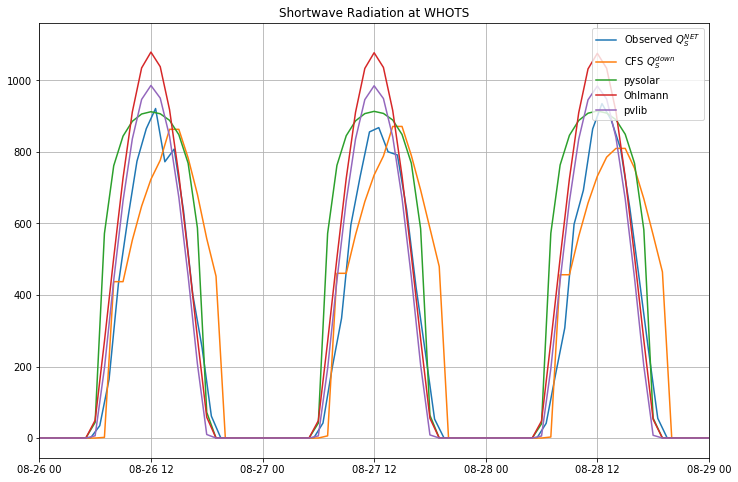

In [14]:
# make a comparison between the different records
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,8))
ax.plot(obs_time,obs_qs,label='Observed $Q_{S}^{NET}$')
ax.plot(cfs_time,cfs_qs_down,label='CFS $Q_{S}^{down}$')
ax.plot(cls_data['Time'],cls_data['pysolar'],label='pysolar')
ax.plot(cls_data['Time'],cls_data['ohlmann'],label='Ohlmann')
ax.plot(cls_data['Time'],cls_data['pvlib'],label='pvlib')
plt.legend()

# zoom in to some arbirary two day period
ax.set_xlim([datetime.date(2004, 8, 26), datetime.date(2004, 8, 29)])
ax.grid()
ax.set_title('Shortwave Radiation at '+ site)

In [15]:
# make a single DataFrame
obs_data = pd.DataFrame({'Time':obs_time, 'obs_qs': obs_qs, 'obs_rain': obs_rain})
cfs_data = pd.DataFrame({'Time':cfs_time, 'cfs_down': cfs_qs_down, 'cfs_up': cfs_qs_up, 'cfs_rain': cfs_rain})
temp = pd.merge_asof(obs_data,cfs_data,on='Time', tolerance=pd.Timedelta('60 minute'))
AllData = pd.merge_asof(temp,cls_data,on='Time',tolerance=pd.Timedelta('60 minute')) 

Correlation CFS downward to Ohlmann clear sky: 0.7531468364345145
Correlation CFS downward to pysolar clear sky: 0.7397742872641588
Correlation CFS downward to pvlib clear sky: 0.7401469723435539
Correlation CFS net to Observations: 0.763451174678133
Correlation Observations to Ohlmann clear sky: 0.9688660730505048
Correlation CFS downward to CFS upward: 0.9882240787637172


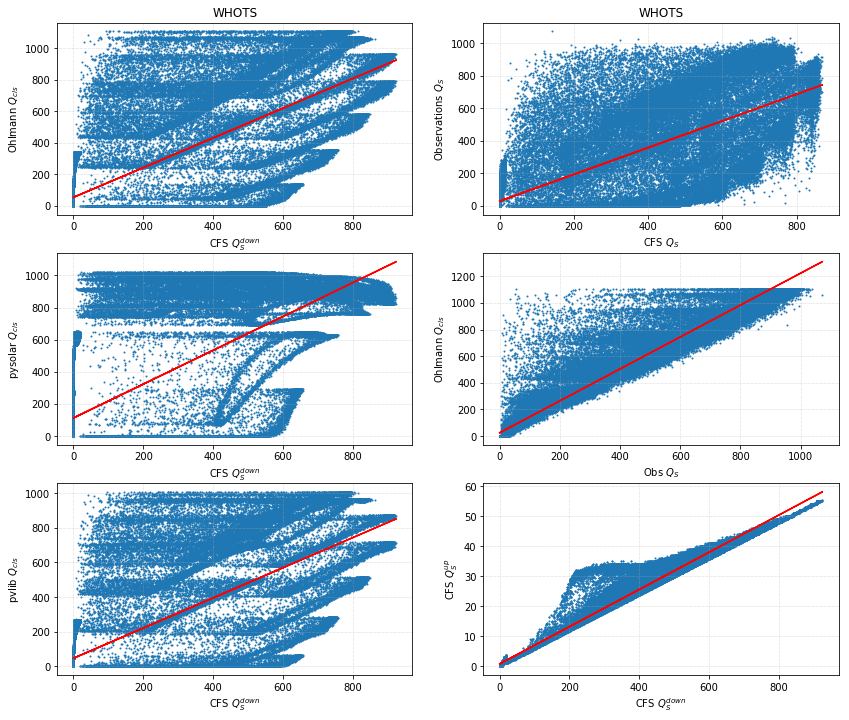

In [16]:
# Do correlation/scatter plots

fig, ax = plt.subplots(nrows=3,ncols=2,figsize=(14,12))

# 1. upper left is CFS downward vs. Ohlmann clearsky
x = AllData['cfs_down']
y = AllData['ohlmann']
ax[0,0].scatter(x,y,s=1,rasterized=True)
idx = np.isfinite(x) & np.isfinite(y)
B = np.polyfit(x[idx],y[idx],1)
A = np.polyval(B,x)
ax[0,0].plot(x,A,color='red')
Zx = ( x[idx] - np.mean(x[idx]) ) / np.std(x[idx])
Zy = ( y[idx] - np.mean(y[idx]) ) / np.std(y[idx])
C = np.polyfit(Zx,Zy,1)
print('Correlation CFS downward to Ohlmann clear sky: ' + str(C[0]) )
ax[0,0].set_xlabel('CFS $Q_{S}^{down}$')
ax[0,0].set_ylabel('Ohlmann $Q_{cls}$')
ax[0,0].set_title(site)
ax[0,0].grid(linestyle=':', linewidth=0.5)

# 2. middle left is CFS downward vs. pysolar clearsky
x = AllData['cfs_down']
y = AllData['pysolar']
ax[1,0].scatter(x,y,s=1,rasterized=True)
idx = np.isfinite(x) & np.isfinite(y)
B = np.polyfit(x[idx],y[idx],1)
A = np.polyval(B,x)
ax[1,0].plot(x,A,color='red')
Zx = ( x[idx] - np.mean(x[idx]) ) / np.std(x[idx])
Zy = ( y[idx] - np.mean(y[idx]) ) / np.std(y[idx])
C = np.polyfit(Zx,Zy,1)
print('Correlation CFS downward to pysolar clear sky: ' + str(C[0]) )
ax[1,0].set_xlabel('CFS $Q_{S}^{down}$')
ax[1,0].set_ylabel('pysolar $Q_{cls}$')
ax[1,0].grid(linestyle=':', linewidth=0.5)

# 3. lower left is CFS downward vs. Ohlmann clearsky
x = AllData['cfs_down']
y = AllData['pvlib']
ax[2,0].scatter(x,y,s=1,rasterized=True)
idx = np.isfinite(x) & np.isfinite(y)
B = np.polyfit(x[idx],y[idx],1)
A = np.polyval(B,x)
ax[2,0].plot(x,A,color='red')
Zx = ( x[idx] - np.mean(x[idx]) ) / np.std(x[idx])
Zy = ( y[idx] - np.mean(y[idx]) ) / np.std(y[idx])
C = np.polyfit(Zx,Zy,1)
print('Correlation CFS downward to pvlib clear sky: ' + str(C[0]) )
ax[2,0].set_xlabel('CFS $Q_{S}^{down}$')
ax[2,0].set_ylabel('pvlib $Q_{cls}$')
ax[2,0].grid(linestyle=':', linewidth=0.5)

# 4. upper right is CFS net vs. observations
x = AllData['cfs_down']-AllData['cfs_up']
y = AllData['obs_qs']
#x2 = x[2:-1]
#y2 = y[0:-3]
ax[0,1].scatter(x,y,s=1,rasterized=True)
idx = np.isfinite(x) & np.isfinite(y)
B = np.polyfit(x[idx],y[idx],1)
A = np.polyval(B,x)
ax[0,1].plot(x,A,color='red')
Zx = ( x[idx] - np.mean(x[idx]) ) / np.std(x[idx])
Zy = ( y[idx] - np.mean(y[idx]) ) / np.std(y[idx])
C = np.polyfit(Zx,Zy,1)
print('Correlation CFS net to Observations: ' + str(C[0]) )
ax[0,1].set_xlabel('CFS $Q_{S}$')
ax[0,1].set_ylabel('Observations $Q_{S}$')
ax[0,1].set_title(site)
ax[0,1].grid(linestyle=':', linewidth=0.5)

# 5. middle right is obs vs. Ohlmann clearsky
x = AllData['obs_qs']
y = AllData['ohlmann']
ax[1,1].scatter(x,y,s=1,rasterized=True)
idx = np.isfinite(x) & np.isfinite(y)
B = np.polyfit(x[idx],y[idx],1)
A = np.polyval(B,x)
ax[1,1].plot(x,A,color='red')
Zx = ( x[idx] - np.mean(x[idx]) ) / np.std(x[idx])
Zy = ( y[idx] - np.mean(y[idx]) ) / np.std(y[idx])
C = np.polyfit(Zx,Zy,1)
print('Correlation Observations to Ohlmann clear sky: ' + str(C[0]) )
ax[1,1].set_xlabel('Obs $Q_{S}$')
ax[1,1].set_ylabel('Ohlmann $Q_{cls}$')
ax[1,1].grid(linestyle=':', linewidth=0.5)

# 6. lower right is CFS downward vs. CFS upward (albedo)
x = AllData['cfs_down']
y = AllData['cfs_up']
ax[2,1].scatter(x,y,s=1,rasterized=True)
idx = np.isfinite(x) & np.isfinite(y)
B = np.polyfit(x[idx],y[idx],1)
A = np.polyval(B,x)
ax[2,1].plot(x,A,color='red')
Zx = ( x[idx] - np.mean(x[idx]) ) / np.std(x[idx])
Zy = ( y[idx] - np.mean(y[idx]) ) / np.std(y[idx])
C = np.polyfit(Zx,Zy,1)
print('Correlation CFS downward to CFS upward: ' + str(C[0]) )
ax[2,1].set_xlabel('CFS $Q_{S}^{down}$')
ax[2,1].set_ylabel('CFS $Q_{S}^{up}$')
ax[2,1].grid(linestyle=':', linewidth=0.5)

Just an example of saving these DataFrames to an ascii CSV

In [26]:
# Example saving DataFrame to csv file
AllData.to_csv('mydf.dat', sep=',')

## 2a.  Albedo
As noted above, the albedo is a measurement of reflected shortwave to incoming.  Most models, including the calculation of net shortwave for the buoys, use a constant value of about 0.05 for the tropical ocean.  Here we look at the validity of this choice.

First, a ratio of the observed shortwave to the clear-sky should provide one clue.

Mean albedo = inf


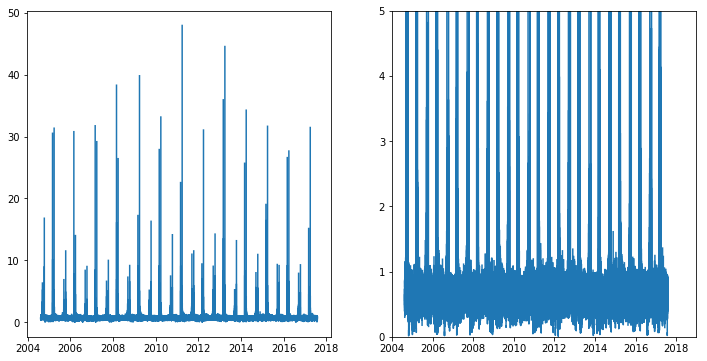

In [31]:
# compare clearsky to measured
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,6))
t = AllData['Time']
y = AllData['obs_qs']/AllData['ohlmann']
ax[0].plot(t,y)
ax[1].plot(t,y)
ax[1].set_xlim([datetime.date(2004, 1, 1), datetime.date(2018, 12, 31)])
ax[1].set_ylim(0,5)
print('Mean albedo = ' + str(np.nanmean(y)))

Mean albedo = 0.0686428999496333


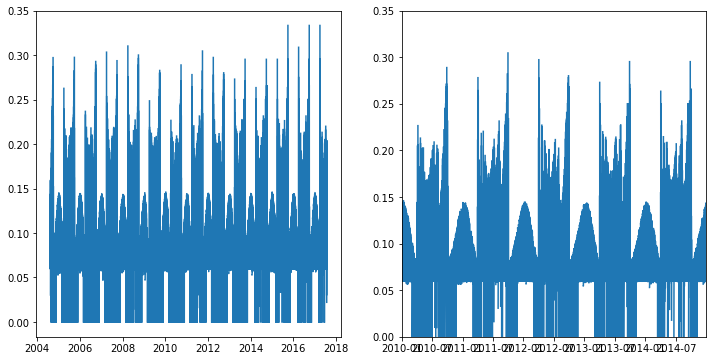

In [32]:
# compare CFS up and downward (result should be albedo)
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,6))
y = AllData['cfs_up']/AllData['cfs_down']
t = AllData['Time']
ax[0].plot(t,y)
ax[1].plot(t,y)
ax[1].set_xlim([datetime.date(2010, 1, 1), datetime.date(2014, 12, 31)])
ax[1].set_ylim(0,0.35)
print('Mean albedo = ' + str(np.nanmean(y)))

## 2b. Lower-frequency comparisons

In [33]:
def movingaverage(interval, window_size):
   window= np.ones(int(window_size))/float(window_size)
   return np.convolve( interval, window, 'valid' )

In [34]:
# Here we do some operations on time, e.g., daily mean, sums, etc.  To do this we need to replace 
# the DataFrame index to be time.  I also add in rainfall
# read precip data from PERSIANN
infile = '/Volumes/JIMP_DATA2/PERSIANN_HOURLY/' + site + '_precip.dat'
r = pd.read_csv(infile, sep=' ', header=None)
rain = r[1]
rain[rain<0.0] = 0.0
rtime = pd.to_datetime([i for i in range(len(r))], unit='h', origin = pd.Timestamp('2003-01-01 00:00:00'))
rain_data = pd.DataFrame({'Time':rtime, 'persiann_rain': rain})
AllData2 = pd.merge_asof(AllData,rain_data,on='Time',tolerance=pd.Timedelta('60 minute')) 
AllData3 = AllData2.set_index(AllData2['Time'])
AllData3 = AllData3.drop(columns='Time')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Mean Obs: 1827597.6284175764
Mean CFS: 2074115.2358401422
Mean Ohlmann: 2388401.919120193
Mean Obs: 164015.17178106462
Mean CFS: 186138.54680616668
Mean Ohlmann: 214343.76197232472
Mean Obs: 5401.386277780469
Mean CFS: 6129.958476200549
Mean Olhmann: 7058.819266979662


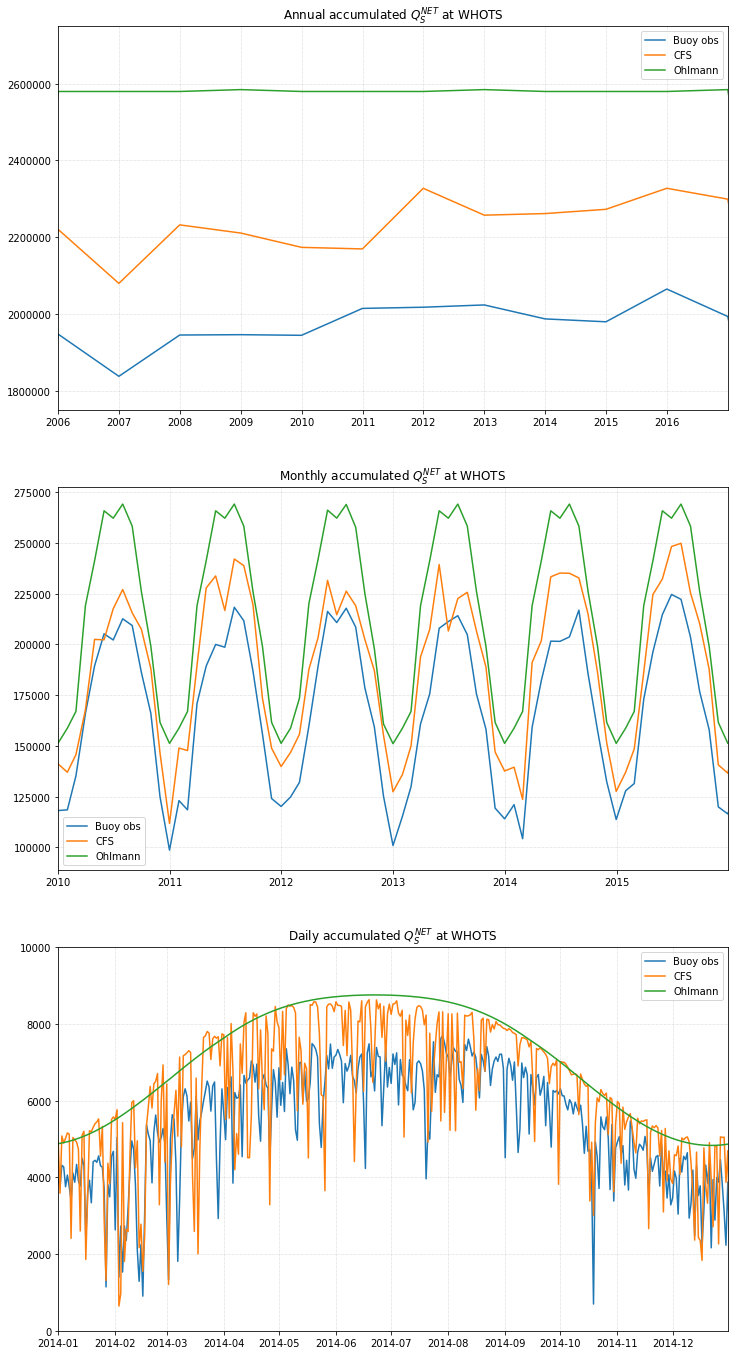

In [63]:
# A few examples: 
#  1. compute daily mean (e.g.)
#AllData3.resample('D').mean()
#  2. compute daily/monthly accumulation
fig, ax = plt.subplots( nrows = 3, ncols = 1, figsize = ( 12, 24 ) )
# annual
ax[0].plot(AllData3['obs_qs'].resample('Y').sum(),label='Buoy obs')
ax[0].plot(AllData3['cfs_down'].resample('Y').sum(),label='CFS')
ax[0].plot(AllData3['ohlmann'].resample('Y').sum(),label='Ohlmann')
ax[0].set_xlim([datetime.date(2006, 1, 1), datetime.date(2016, 12, 31)])
ax[0].set_ylim(1750000,2750000)
ax[0].set_title('Annual accumulated $Q_{S}^{NET}$ at ' + site)
ax[0].legend()
ax[0].grid(linestyle=':', linewidth=0.5)
print('Mean Obs: ' + str(np.nanmean(AllData3['obs_qs'].resample('Y').sum())))
print('Mean CFS: ' + str(np.nanmean(AllData3['cfs_down'].resample('Y').sum())))
print('Mean Ohlmann: ' + str(np.nanmean(AllData3['ohlmann'].resample('Y').sum())))

# monthy
ax[1].plot(AllData3['obs_qs'].resample('M').sum(),label='Buoy obs')
ax[1].plot(AllData3['cfs_down'].resample('M').sum(),label='CFS')
ax[1].plot(AllData3['ohlmann'].resample('M').sum(),label='Ohlmann')
ax[1].set_xlim([datetime.date(2010, 1, 1), datetime.date(2015, 12, 31)])
#ax[1].set_ylim(0,10000)
ax[1].set_title('Monthly accumulated $Q_{S}^{NET}$ at ' + site)
ax[1].legend()
ax[1].grid(linestyle=':', linewidth=0.5)
print('Mean Obs: ' + str(np.nanmean(AllData3['obs_qs'].resample('M').sum())))
print('Mean CFS: ' + str(np.nanmean(AllData3['cfs_down'].resample('M').sum())))
print('Mean Ohlmann: ' + str(np.nanmean(AllData3['ohlmann'].resample('M').sum())))

# daily
ax[2].plot(AllData3['obs_qs'].resample('D').sum(),label='Buoy obs')
ax[2].plot(AllData3['cfs_down'].resample('D').sum(),label='CFS')
ax[2].plot(AllData3['ohlmann'].resample('D').sum(),label='Ohlmann')
ax[2].set_xlim([datetime.date(2014, 1, 1), datetime.date(2014, 12, 31)])
ax[2].set_ylim(0,10000)
ax[2].set_title('Daily accumulated $Q_{S}^{NET}$ at ' + site)
ax[2].legend()
ax[2].grid(linestyle=':', linewidth=0.5)
print('Mean Obs: ' + str(np.nanmean(AllData3['obs_qs'].resample('D').sum())))
print('Mean CFS: ' + str(np.nanmean(AllData3['cfs_down'].resample('D').sum())))
print('Mean Olhmann: ' + str(np.nanmean(AllData3['ohlmann'].resample('D').sum())))

# save figure
plt.savefig('qs_accum.png')

Mean Obs: 990.8126396347579
Mean CFS: 915.2624947857142
Mean Ohlmann: 1104.853846884045
Mean Obs: 892.9635365647453
Mean CFS: 818.7229368012821
Mean Ohlmann: 993.1867840765535
Mean Obs: 797.0736614153161
Mean CFS: 723.9799290671311
Mean Olhmann: 962.8289680638834


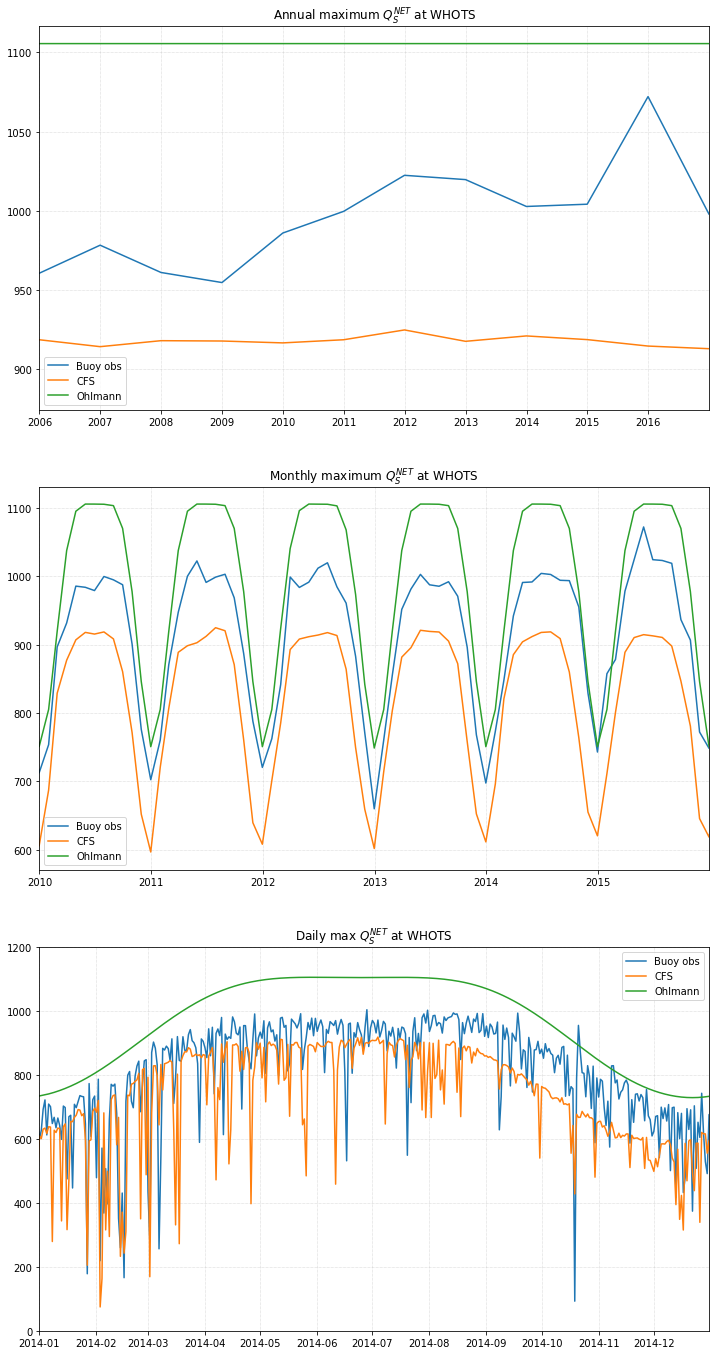

In [66]:
# try comparison of daily max Qs
fig, ax = plt.subplots( nrows = 3, ncols = 1, figsize = ( 12, 24 ) )

# annual
grouped = AllData3.groupby(pd.Grouper(freq='Y'))
x = grouped['obs_qs'].max()
y = grouped['cfs_down'].max()
z = grouped['ohlmann'].max()
ax[0].plot(x,label='Buoy obs')
ax[0].plot(y,label='CFS')
ax[0].plot(z,label='Ohlmann')
ax[0].set_xlim([datetime.date(2006, 1, 1), datetime.date(2016, 12, 31)])
#ax[0].set_ylim(1750000,2750000)
ax[0].set_title('Annual maximum $Q_{S}^{NET}$ at ' + site)
ax[0].legend()
ax[0].grid(linestyle=':', linewidth=0.5)
print('Mean Obs: ' + str(np.nanmean(x)))
print('Mean CFS: ' + str(np.nanmean(y)))
print('Mean Ohlmann: ' + str(np.nanmean(z)))

# monthy
grouped = AllData3.groupby(pd.Grouper(freq='M'))
x = grouped['obs_qs'].max()
y = grouped['cfs_down'].max()
z = grouped['ohlmann'].max()
ax[1].plot(x,label='Buoy obs')
ax[1].plot(y,label='CFS')
ax[1].plot(z,label='Ohlmann')
ax[1].set_xlim([datetime.date(2010, 1, 1), datetime.date(2015, 12, 31)])
#ax[1].set_ylim(0,10000)
ax[1].set_title('Monthly maximum $Q_{S}^{NET}$ at ' + site)
ax[1].legend()
ax[1].grid(linestyle=':', linewidth=0.5)
print('Mean Obs: ' + str(np.nanmean(x)))
print('Mean CFS: ' + str(np.nanmean(y)))
print('Mean Ohlmann: ' + str(np.nanmean(z)))

# daily
grouped = AllData3.groupby(pd.Grouper(freq='D'))
x = grouped['obs_qs'].max()
y = grouped['cfs_down'].max()
z = grouped['ohlmann'].max()
ax[2].plot(x,label='Buoy obs')
ax[2].plot(y,label='CFS')
ax[2].plot(z,label='Ohlmann')
ax[2].set_xlim([datetime.date(2014, 1, 1), datetime.date(2014, 12, 31)])
ax[2].set_ylim(0,1200)
ax[2].set_title('Daily max $Q_{S}^{NET}$ at ' + site)
ax[2].legend()
ax[2].grid(linestyle=':', linewidth=0.5)
print('Mean Obs: ' + str(np.nanmean(x)))
print('Mean CFS: ' + str(np.nanmean(y)))
print('Mean Olhmann: ' + str(np.nanmean(z)))

# save figure
plt.savefig('qs_max.png')

Correlation max daily obs to CFS: 0.7060767796653306
Correlation max daily obs to Ohlmann: 0.7690514507812781
Correlation max daily CFS to Ohlmann: 0.6821400827220435


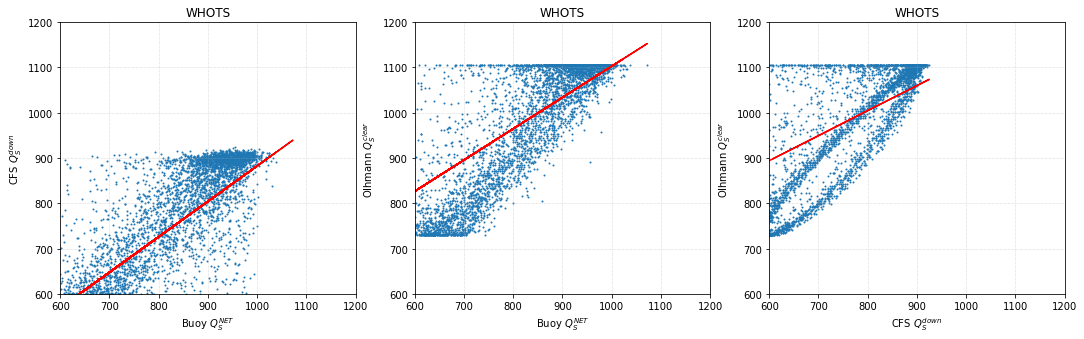

In [36]:
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(18,5))

ax[0].scatter(x,y,s=1,rasterized=True)
idx = np.isfinite(x) & np.isfinite(y)
B = np.polyfit(x[idx],y[idx],1)
A = np.polyval(B,x)
ax[0].plot(x,A,color='red')
Zx = ( x[idx] - np.mean(x[idx]) ) / np.std(x[idx])
Zy = ( y[idx] - np.mean(y[idx]) ) / np.std(y[idx])
C = np.polyfit(Zx,Zy,1)
print('Correlation max daily obs to CFS: ' + str(C[0]) )
ax[0].set_xlabel('Buoy $Q_{S}^{NET}$')
ax[0].set_ylabel('CFS $Q_{S}^{down}$')
ax[0].set_title(site)
ax[0].set_xlim(600, 1200)
ax[0].set_ylim(600, 1200)
ax[0].grid(linestyle=':', linewidth=0.5)

ax[1].scatter(x,z,s=1,rasterized=True)
idx = np.isfinite(x) & np.isfinite(z)
B = np.polyfit(x[idx],z[idx],1)
A = np.polyval(B,x)
ax[1].plot(x,A,color='red')
Zx = ( x[idx] - np.mean(x[idx]) ) / np.std(x[idx])
Zy = ( z[idx] - np.mean(z[idx]) ) / np.std(z[idx])
C = np.polyfit(Zx,Zy,1)
print('Correlation max daily obs to Ohlmann: ' + str(C[0]) )
ax[1].set_xlabel('Buoy $Q_{S}^{NET}$')
ax[1].set_ylabel('Olhmann $Q_{S}^{clear}$')
ax[1].set_title(site)
ax[1].set_xlim(600, 1200)
ax[1].set_ylim(600, 1200)
ax[1].grid(linestyle=':', linewidth=0.5)

ax[2].scatter(y,z,s=1,rasterized=True)
idx = np.isfinite(y) & np.isfinite(z)
B = np.polyfit(y[idx],z[idx],1)
A = np.polyval(B,y)
ax[2].plot(y,A,color='red')
Zx = ( y[idx] - np.mean(y[idx]) ) / np.std(y[idx])
Zy = ( z[idx] - np.mean(z[idx]) ) / np.std(z[idx])
C = np.polyfit(Zx,Zy,1)
print('Correlation max daily CFS to Ohlmann: ' + str(C[0]) )
ax[2].set_xlabel('CFS $Q_{S}^{down}$')
ax[2].set_ylabel('Olhmann $Q_{S}^{clear}$')
ax[2].set_title(site)
ax[2].set_xlim(600, 1200)
ax[2].set_ylim(600, 1200)
ax[2].grid(linestyle=':', linewidth=0.5)

The best correlation is Ohlmann clear-sky to the observations.  The CFS up and down shortwave are very highly correlated, thus suggesting a constant albedo is appropriate.

To next investigate clouds, we try to look at the correlation of shortwave to rainfall.  To do this we read rain from PERSIANN (satellite-derived) and compare to the CFS and buoy rainfall estimates

## 3.  Rainfall as proxy for clouds?

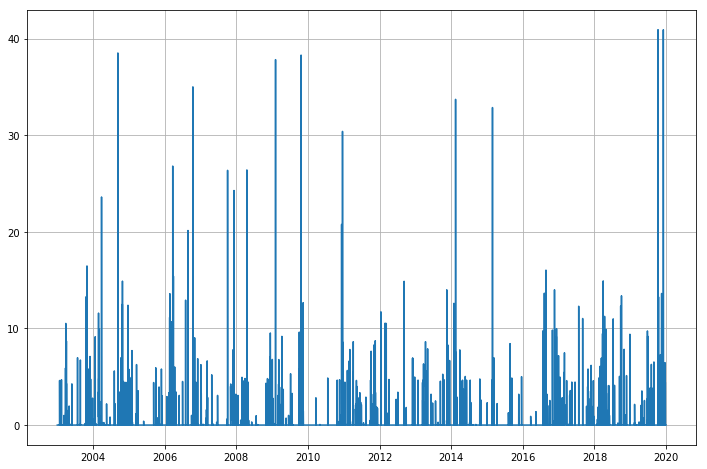

In [37]:
fig, ax = plt.subplots( figsize = ( 12, 8 ) )
ax.plot(rtime,rain)
plt.grid()

Correlation Observed to CFS rainfaill: 0.13265985374988337
Correlation Observed to PERSIANN rainfaill: 0.07059145634942011
Correlation CFS to PERSIANN rainfaill: 0.07865182407823687
Correlation clouds to PERSIANN rainfaill: 0.023258030603506945


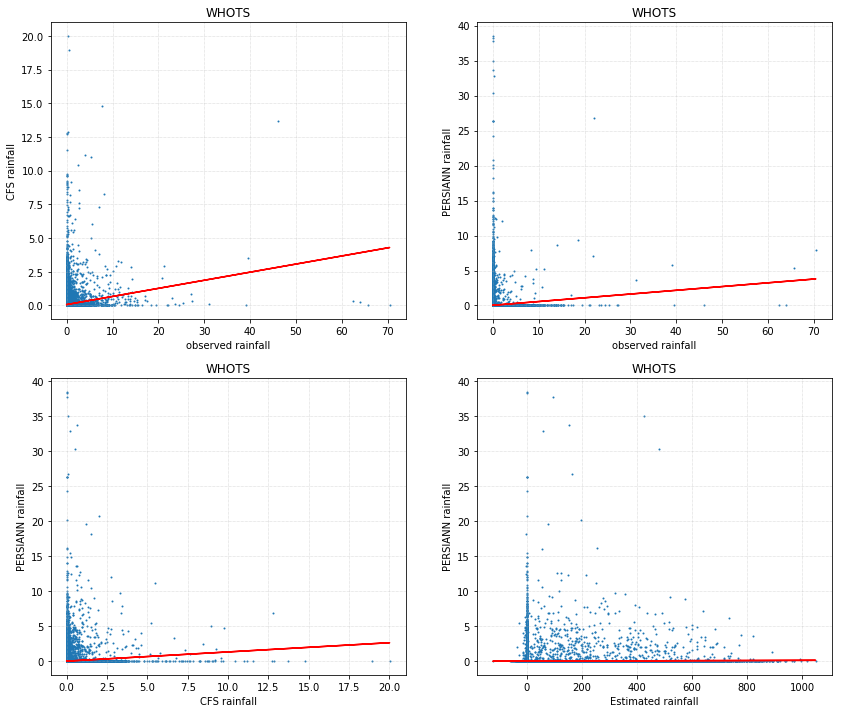

In [38]:
# make some correlation plots
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(14,12))

# 1. Upper left observed vs. CFS rain
x = AllData2['obs_rain']
y = AllData2['cfs_rain']
ax[0,0].scatter(x,y,s=1,rasterized=True)
idx = np.isfinite(x) & np.isfinite(y)
B = np.polyfit(x[idx],y[idx],1)
A = np.polyval(B,x)
ax[0,0].plot(x,A,color='red')
Zx = ( x[idx] - np.mean(x[idx]) ) / np.std(x[idx])
Zy = ( y[idx] - np.mean(y[idx]) ) / np.std(y[idx])
C = np.polyfit(Zx,Zy,1)
print('Correlation Observed to CFS rainfaill: ' + str(C[0]) )
ax[0,0].set_xlabel('observed rainfall')
ax[0,0].set_ylabel('CFS rainfall')
ax[0,0].set_title(site)
ax[0,0].grid(linestyle=':', linewidth=0.5)

# 2. Upper right observed vs. PERSIANN rain
x = AllData2['obs_rain']
y = AllData2['persiann_rain']
ax[0,1].scatter(x,y,s=1,rasterized=True)
idx = np.isfinite(x) & np.isfinite(y)
B = np.polyfit(x[idx],y[idx],1)
A = np.polyval(B,x)
ax[0,1].plot(x,A,color='red')
Zx = ( x[idx] - np.mean(x[idx]) ) / np.std(x[idx])
Zy = ( y[idx] - np.mean(y[idx]) ) / np.std(y[idx])
C = np.polyfit(Zx,Zy,1)
print('Correlation Observed to PERSIANN rainfaill: ' + str(C[0]) )
ax[0,1].set_xlabel('observed rainfall')
ax[0,1].set_ylabel('PERSIANN rainfall')
ax[0,1].set_title(site)
ax[0,1].grid(linestyle=':', linewidth=0.5)

# 3. Lower left CFS vs. PERSIANN rain
x = AllData2['cfs_rain']
y = AllData2['persiann_rain']
ax[1,0].scatter(x,y,s=1,rasterized=True)
idx = np.isfinite(x) & np.isfinite(y)
B = np.polyfit(x[idx],y[idx],1)
A = np.polyval(B,x)
ax[1,0].plot(x,A,color='red')
Zx = ( x[idx] - np.mean(x[idx]) ) / np.std(x[idx])
Zy = ( y[idx] - np.mean(y[idx]) ) / np.std(y[idx])
C = np.polyfit(Zx,Zy,1)
print('Correlation CFS to PERSIANN rainfaill: ' + str(C[0]) )
ax[1,0].set_xlabel('CFS rainfall')
ax[1,0].set_ylabel('PERSIANN rainfall')
ax[1,0].set_title(site)
ax[1,0].grid(linestyle=':', linewidth=0.5)

# 3. Lower right estimated clouds vs. PERSIANN rain
x = AllData2['ohlmann'] - AllData2['obs_qs']
y = AllData2['persiann_rain']
ax[1,1].scatter(x,y,s=1,rasterized=True)
idx = np.isfinite(x) & np.isfinite(y)
B = np.polyfit(x[idx],y[idx],1)
A = np.polyval(B,x)
ax[1,1].plot(x,A,color='red')
Zx = ( x[idx] - np.mean(x[idx]) ) / np.std(x[idx])
Zy = ( y[idx] - np.mean(y[idx]) ) / np.std(y[idx])
C = np.polyfit(Zx,Zy,1)
print('Correlation clouds to PERSIANN rainfaill: ' + str(C[0]) )
ax[1,1].set_xlabel('Estimated rainfall')
ax[1,1].set_ylabel('PERSIANN rainfall')
ax[1,1].set_title(site)
ax[1,1].grid(linestyle=':', linewidth=0.5)

There does not seem to be any correlation between rainfall and $Q_{S}$-derived clouds.  There is also no correlation between the PERSIANN, CFS and observed rainfall.

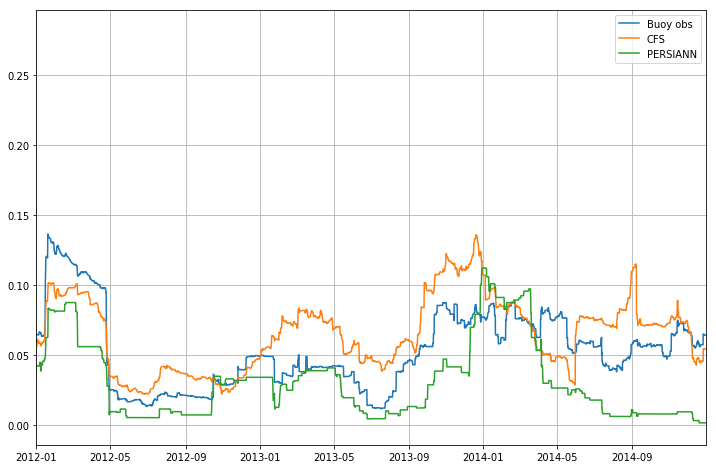

In [39]:
fig, ax = plt.subplots( figsize = ( 12, 8 ) )

obs_lf = movingaverage(AllData2['obs_rain'],2400)
cfs_lf = movingaverage(AllData2['cfs_rain'],2400)
per_lf = movingaverage(AllData2['persiann_rain'],2400)
obs_lf = np.append(obs_lf,[np.nan]*1200)
obs_lf = np.append([np.nan]*1199,obs_lf)
cfs_lf = np.append(cfs_lf,[np.nan]*1200)
cfs_lf = np.append([np.nan]*1199,cfs_lf)
per_lf = np.append(per_lf,[np.nan]*1200)
per_lf = np.append([np.nan]*1199,per_lf)

ax.plot(AllData2['Time'],obs_lf,label='Buoy obs')
ax.plot(AllData2['Time'],cfs_lf,label='CFS')
ax.plot(AllData2['Time'],per_lf,label='PERSIANN')
ax.set_xlim([datetime.date(2012, 1, 1), datetime.date(2014, 12, 31)])
plt.legend()
plt.grid()

In [40]:
x = obs_lf
y = cfs_lf
z = per_lf

idx = np.isfinite(x) & np.isfinite(y)
B = np.polyfit(x[idx],y[idx],1)
A = np.polyval(B,x)
Zx = ( x[idx] - np.mean(x[idx]) ) / np.std(x[idx])
Zy = ( y[idx] - np.mean(y[idx]) ) / np.std(y[idx])
C = np.polyfit(Zx,Zy,1)
print('Correlation low-pass buoy to CFS rainfaill: ' + str(C[0]) )

idx = np.isfinite(x) & np.isfinite(z)
B = np.polyfit(x[idx],z[idx],1)
A = np.polyval(B,x)
Zx = ( x[idx] - np.mean(x[idx]) ) / np.std(x[idx])
Zz = ( z[idx] - np.mean(z[idx]) ) / np.std(z[idx])
C = np.polyfit(Zx,Zz,1)
print('Correlation low-pass buoy to PERSIANN rainfaill: ' + str(C[0]) )

idx = np.isfinite(y) & np.isfinite(z)
B = np.polyfit(y[idx],z[idx],1)
A = np.polyval(B,y)
Zy = ( y[idx] - np.mean(y[idx]) ) / np.std(y[idx])
Zz = ( z[idx] - np.mean(z[idx]) ) / np.std(z[idx])
C = np.polyfit(Zy,Zz,1)
print('Correlation low-pass CFS to PERSIANN rainfaill: ' + str(C[0]) )

Correlation low-pass buoy to CFS rainfaill: 0.6994457503517978
Correlation low-pass buoy to PERSIANN rainfaill: 0.6968897069833709
Correlation low-pass CFS to PERSIANN rainfaill: 0.7174420174498457


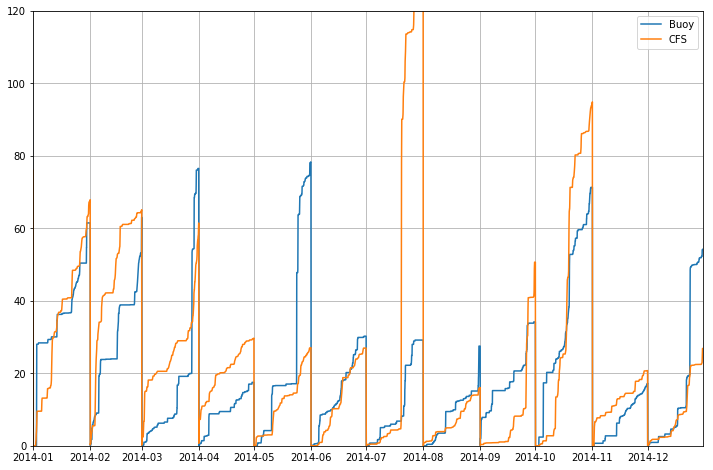

In [41]:
fig, ax = plt.subplots( figsize = ( 12, 8 ) )

# rolling sum (like a running mean)
#plt.plot(AllData3['obs_rain'].rolling(2400).sum())

# cummulative
#plt.plot(AllData3.obs_rain.cumsum())
#plt.plot(AllData3['persiann_rain'].cumsum())
#plt.plot(AllData3['cfs_rain'].cumsum())

# cummulative over certain time range (annual, 'y')
df = AllData3.groupby('Time').obs_rain.sum()
df = df.groupby(df.index.to_period('M')).cumsum().reset_index()
df2 = AllData3.groupby('Time').cfs_rain.sum()
df2 = df2.groupby(df2.index.to_period('M')).cumsum().reset_index()

ax.plot(df['Time'],df['obs_rain'],label='Buoy')
ax.plot(df['Time'],df2['cfs_rain'],label='CFS')
ax.set_xlim([datetime.date(2014, 1, 1), datetime.date(2014, 12,31)])
ax.set_ylim([0, 120])
plt.legend()
plt.grid()